# Model Training: Forwards - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Forward position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import  KFold
import shap
shap.initjs()

In [36]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for All Players')

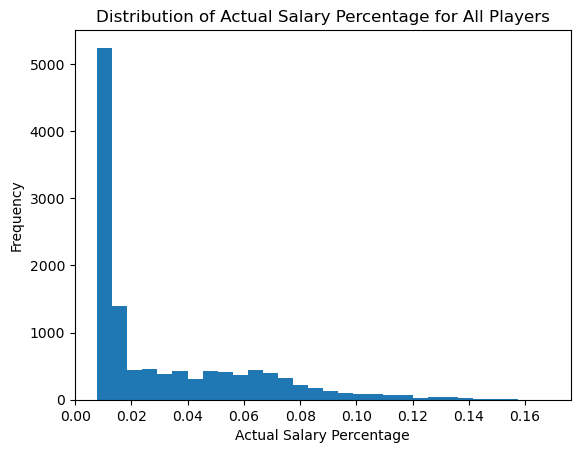

In [37]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(data['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for All Players')

In [38]:
forwards = data[data['POSITION'].isin(['r', 'l', 'c, l', 'c', 'l, r', 'c, r'])].copy()

# Select only players with 41 or more games played
forwards_41GP = forwards[(forwards['GP'] >= 41)].copy()
test_train_data = forwards_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

In [39]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

# X = test_train_data[numerical_features]

# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

In [53]:
# Assuming 'test_train_data' and 'numerical_features' are defined as in your script
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator for RFE
estimator = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1000, max_depth=5, reg_lambda=2, eta=0.01)

# Define the pipeline as before
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# Use RFECV with cross-validation for automated feature selection
# Set min_features_to_select to 1 to ensure at least one feature is selected
# cv=n for n-fold cross-validation
rfecv = RFECV(estimator=estimator, step=1, cv=KFold(2), scoring='neg_mean_squared_error', min_features_to_select=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', rfecv),
                           ('regressor', estimator)])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Optimal number of features : {rfecv.n_features_}')

Mean Squared Error: 0.0005066640029095787
Optimal number of features : 103


In [54]:
# Print the training performance score
print(f'Training performance score: {rfecv.score(X_train, y_train)}')

# Print the testing performance score
print(f'Testing performance score: {rfecv.score(X_test, y_test)}')

# 
# Training performance score: -0.9545108043315635
# Testing performance score: -1.0734563919849927

Training performance score: -1.0374227196780428
Testing performance score: -1.146768914145102


/Users/michaelkuby/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/Users/michaelkuby/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [42]:
# Save the model to a file
import joblib

model_dir = 'Forward_Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

joblib.dump(pipeline, f'{model_dir}/forward_salary_pipeline.pkl')
joblib.dump(numerical_features, f'{model_dir}/forward_salary_features.pkl')

['Forward_Model/forward_salary_features.pkl']

In [43]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [44]:
# Create a feature column in Centers for the predicted salary
forwards['PRED_SALARY_PERCENTAGE'] = pipeline.predict(forwards)

# Create a column for the actual predicted salary
forwards['PRED_AAV'] = forwards['PRED_SALARY_PERCENTAGE'] * forwards['SALARY CAP']
forwards['PRED_AAV'] = forwards['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
forwards['DIFF'] = forwards['PRED_AAV'] - forwards['AAV']

# Convert to dollars
forwards['PRED_AAV'] = convert_to_dollars(forwards, 'PRED_AAV')
forwards['AAV'] = convert_to_dollars(forwards, 'AAV')
forwards['DIFF'] = convert_to_dollars(forwards, 'DIFF')

In [45]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = forwards.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
952,alex ovechkin,2009-10,"$9,538,462.00","$9,203,793.00","$-334,669.00",0.162039
424,alex ovechkin,2008-09,"$9,538,462.00","$9,127,230.00","$-411,232.00",0.160974
2812,alex ovechkin,2012-13,"$9,538,462.00","$9,049,959.00","$-488,503.00",0.150833
41,brad richards,2007-08,"$7,800,000.00","$7,290,927.00","$-509,073.00",0.144949
11910,nathan mackinnon,2023-24,"$12,600,000.00","$12,060,077.00","$-539,923.00",0.144432
9143,connor mcdavid,2020-21,"$12,500,000.00","$11,758,865.00","$-741,135.00",0.144281
1454,sidney crosby,2009-10,"$8,700,000.00","$8,186,575.00","$-513,425.00",0.144130
881,sidney crosby,2008-09,"$8,700,000.00","$8,134,594.00","$-565,406.00",0.143467
9045,auston matthews,2020-21,"$11,640,250.00","$11,680,794.00","$40,544.00",0.143323
1141,evgeni malkin,2009-10,"$8,700,000.00","$8,113,112.00","$-586,888.00",0.142836


In [46]:
# Display all seasons for Connor McDavid
connor_mcdavid = forwards[forwards['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
5276,connor mcdavid,2015-16,"$3,775,000.00","$2,536,766.00","$-1,238,234.00",0.035529
6071,connor mcdavid,2016-17,"$3,775,000.00","$6,322,438.00","$2,547,438.00",0.086609
6841,connor mcdavid,2017-18,"$3,775,000.00","$2,742,928.00","$-1,032,072.00",0.036572
7617,connor mcdavid,2018-19,"$12,500,000.00","$11,028,792.00","$-1,471,208.00",0.138727
8398,connor mcdavid,2019-20,"$12,500,000.00","$10,881,264.00","$-1,618,736.00",0.133512
9143,connor mcdavid,2020-21,"$12,500,000.00","$11,758,865.00","$-741,135.00",0.144281
9952,connor mcdavid,2021-22,"$12,500,000.00","$10,492,540.00","$-2,007,460.00",0.128743
10786,connor mcdavid,2022-23,"$12,500,000.00","$11,414,355.00","$-1,085,645.00",0.138356
11570,connor mcdavid,2023-24,"$12,500,000.00","$10,172,696.00","$-2,327,304.00",0.121829


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Forwards')

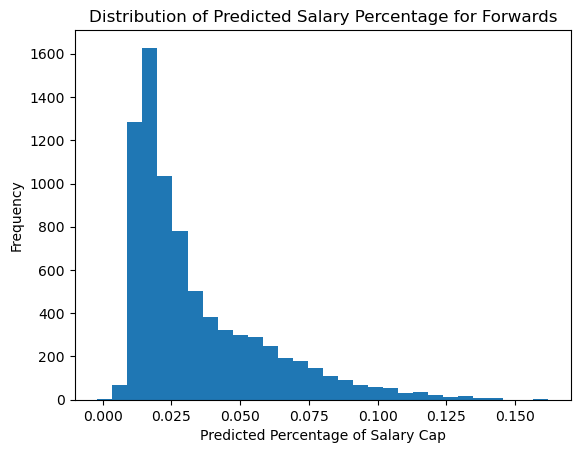

In [47]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(forwards['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Percentage of Salary Cap')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Forwards')

Text(0.5, 1.0, 'Actual Distribution of Salary Cap Percentage for Forwards')

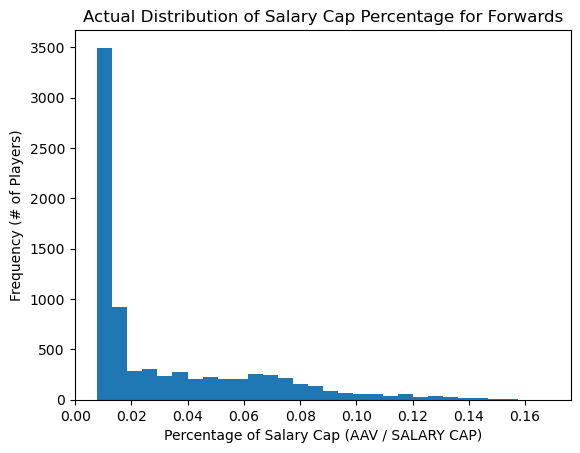

In [48]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(forwards['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Percentage of Salary Cap (AAV / SALARY CAP)')
plt.ylabel('Frequency (# of Players)')
plt.title('Actual Distribution of Salary Cap Percentage for Forwards')

In [49]:
# Filter players with over 41 GP
filtered_data = forwards[(forwards['GP'] > 60) & (forwards['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11539,"buf, col",casey mittelstadt,2023-24,"$2,500,000.00","$6,081,418.00","$3,581,418.00",0.072831,3581418.0
12045,"mtl, wpg",sean monahan,2023-24,"$2,000,000.00","$5,250,521.00","$3,250,521.00",0.062881,3250521.0
11701,bos,james van riemsdyk,2023-24,"$1,000,000.00","$3,950,140.00","$2,950,140.00",0.047307,2950140.0
11754,col,jonathan drouin,2023-24,"$825,000.00","$3,656,623.00","$2,831,623.00",0.043792,2831623.0
11975,chi,philipp kurashev,2023-24,"$2,250,000.00","$4,633,855.00","$2,383,855.00",0.055495,2383855.0
12133,dal,wyatt johnston,2023-24,"$1,000,417.00","$3,366,256.00","$2,365,839.00",0.040314,2365839.0
12070,chi,taylor raddysh,2023-24,"$758,333.00","$3,002,853.00","$2,244,520.00",0.035962,2244520.0
11851,car,martin necas,2023-24,"$3,000,000.00","$5,190,616.00","$2,190,616.00",0.062163,2190616.0
11917,ari,nick bjugstad,2023-24,"$2,100,000.00","$4,285,370.00","$2,185,370.00",0.051322,2185370.0
11541,vgk,chandler stephenson,2023-24,"$2,750,000.00","$4,578,975.00","$1,828,975.00",0.054838,1828975.0


In [50]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12096,tor,tyler bertuzzi,2023-24,"$5,500,000.00","$4,037,935.00","$-1,462,065.00",0.048359,-1462065.0
12004,dal,roope hintz,2023-24,"$8,450,000.00","$6,977,521.00","$-1,472,479.00",0.083563,-1472479.0
11423,fla,aleksander barkov,2023-24,"$10,000,000.00","$8,462,923.00","$-1,537,077.00",0.101352,-1537077.0
12122,"fla, ott",vladimir tarasenko,2023-24,"$5,000,000.00","$3,418,155.00","$-1,581,845.00",0.040936,-1581845.0
11762,stl,jordan kyrou,2023-24,"$8,125,000.00","$6,535,588.00","$-1,589,412.00",0.078271,-1589412.0
11425,det,alex debrincat,2023-24,"$7,875,000.00","$6,252,008.00","$-1,622,992.00",0.074874,-1622992.0
11772,mtl,juraj slafkovsky,2023-24,"$4,450,000.00","$2,822,436.00","$-1,627,564.00",0.033802,-1627564.0
11505,mtl,brendan gallagher,2023-24,"$6,500,000.00","$4,793,147.00","$-1,706,853.00",0.057403,-1706853.0
11413,"ana, edm",adam henrique,2023-24,"$5,825,000.00","$4,089,082.00","$-1,735,918.00",0.048971,-1735918.0
11721,buf,jeff skinner,2023-24,"$9,000,000.00","$7,263,337.00","$-1,736,663.00",0.086986,-1736663.0


In [51]:
filtered_data[filtered_data['PLAYER'] == 'leon draisaitl'][display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
11810,leon draisaitl,2023-24,"$8,500,000.00","$8,849,648.00","$349,648.00",0.105984


In [52]:
predictions = pd.DataFrame(forwards[['PLAYER', 'SEASON', 'TOI/GP', 'PRED_SALARY_PERCENTAGE']])

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'forwards_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=False)